In [1]:
import torch
from transformers import pipeline
import fiftyone as fo
import boto3
import os

import numpy as np
from tqdm import tqdm 
from PIL import Image
import pandas as pd

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from transformers.image_utils import load_image

In [2]:
ds = fo.Dataset.from_dir('data/metadata', fo.types.FiftyOneDataset)
sample = ds.first()

Importing samples...
 100% |███████████████| 2223/2223 [47.8ms elapsed, 0s remaining, 46.5K samples/s]   
Migrating dataset '2025.11.18.18.50.01.509876' to v1.10.0


In [ ]:
import time
from utils2 import load_Siglip2 

device = 'cuda'

model, tokenizer, preprocessor = load_Siglip2()

file_id = sample.filepath.split("/")[-1]
image_path = f"data/samples/{file_id}"

inputs = preprocessor(images=[Image.open(image_path)], return_tensors="pt").to(model.device)


model.to('cuda')
inputs.to('cuda')
start = time.time()

for i in range(100):
    encoding_image = model.get_image_features(
        **inputs
    )
    del encoding_image


end = time.time()
print(end - start)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


19.19321346282959


In [4]:
del model

In [5]:
import time
from utils import load_Siglip

model, tokenizer, preprocessor = load_Siglip()

file_id = sample.filepath.split("/")[-1]
image_path = f"data/samples/{file_id}"

inputs = preprocessor(Image.open(image_path))

model.to('cuda')
start = time.time()

for i in range(100):
    encoding_image = model.encode_image(
        inputs.unsqueeze(0).to('cuda')
    )
    del encoding_image

end = time.time()
print(end - start)

1.4960131645202637


torch.Size([3, 224, 224])

# Load the fiftyone dataset and its images

In [3]:
ds = fo.Dataset.from_dir('data/metadata', fo.types.FiftyOneDataset)
for sample in tqdm(ds): 
    file_id = sample.filepath.split('/')[-1]
    if not os.path.exists(f'data/samples/{file_id}'):
        boto3.client('s3').download_file('reversefashion-images', f"s/{file_id}", f'../data/samples/{file_id}')


from utils2 import load_Siglip2, apply_model_on_ds
%load_ext autoreload
%autoreload 2



def save_df(df_all, translate, checkpoints,candidate_labels, figsize=(16, 6), layout = (2,3)): 

    df_all['pred_processed'] = df_all['pred'].apply(lambda x: translate.get(x))  
    df_all['pred_correct'] = df_all['label'] == df_all['pred_processed']

    grouped_tables = [
        df_all[df_all["checkpoint"] == checkpoint].groupby(['label', 'pred_processed']).size().unstack(fill_value=0)
        for checkpoint in checkpoints
    ]
    # Calculate accuracy for each checkpoint
    def get_accuracy(df, checkpoint):
        df_ckpt = df[df["checkpoint"] == checkpoint]
        if "pred_correct" in df_ckpt.columns:
            return df_ckpt["pred_correct"].mean()
        
    accuracies = [get_accuracy(df_all, checkpoint) for checkpoint in checkpoints]

    # Set up the 3x2 grid
    fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize)
    axes = axes.flatten()

    for idx, (checkpoint, table, acc) in enumerate(zip(checkpoints, grouped_tables, accuracies)):
        ax = axes[idx]
        ax.axis('off')
        tbl = ax.table(
            cellText=table.values,
            rowLabels=table.index,
            colLabels=table.columns,
            loc='center',
            cellLoc='center'
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(12)
        tbl.scale(1.2, 1.2)
        ax.set_title(f"{checkpoint}\nAccuracy: {acc:.2%}", fontsize=14, pad=20)

    # Hide any unused subplots
    for j in range(len(checkpoints), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    filepath = f"{'_'.join(candidate_labels)}.png"
    filepath = filepath.replace("/", "_")
    filepath = f"plots/{filepath}"
    plt.savefig(filepath, dpi=200)
    plt.show()



def calc_labels_suggestion(candidate_labels, category, checkpoints):

    dfs = []

    for checkpoint in checkpoints:
        print(f"Evaluating checkpoint: {checkpoint}")
        # Test Siglip2
        model, tokenizer, processor = load_Siglip2(checkpoint)



        df = apply_model_on_ds(
            ds_temp,
            preprocessor=processor,
            tokenizer=tokenizer,
            model=model,
            target_field=category,
            candidate_labels=candidate_labels,
        )
        del processor, tokenizer, model
        torch.cuda.empty_cache()
        df["checkpoint"] = checkpoint

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

Importing samples...
 100% |███████████████| 2223/2223 [39.1ms elapsed, 0s remaining, 56.9K samples/s]   
Migrating dataset '2025.11.18.13.51.58.029755' to v1.10.0


100%|██████████| 600/600 [00:00<00:00, 1880.25it/s]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gender

## Evaluate Gender of Jeans

Evaluating checkpoint: google/siglip2-large-patch16-256


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 134/134 [00:27<00:00,  4.86it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 134/134 [00:27<00:00,  4.87it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 134/134 [00:27<00:00,  4.87it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 134/134 [00:27<00:00,  4.87it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 134/134 [00:27<00:00,  4.87it/s]


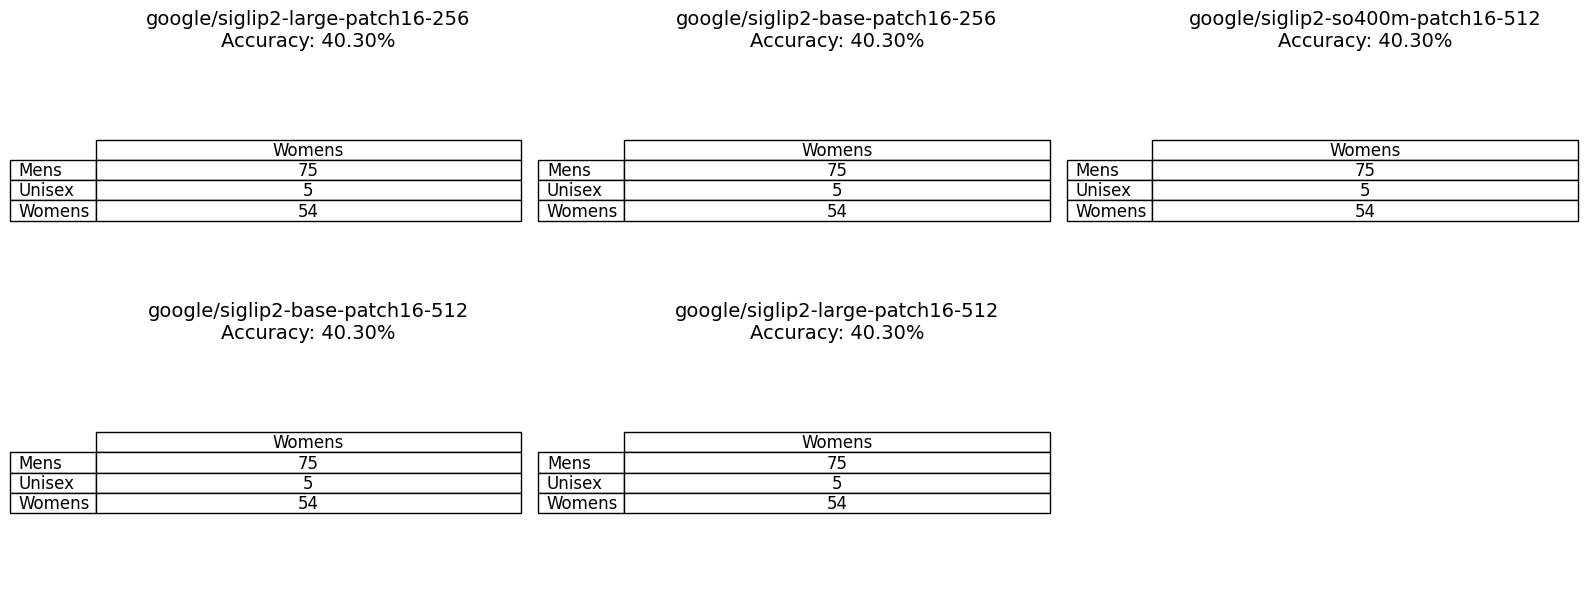

In [4]:
# ds_temp = ds.match(fo.ViewField("Category three").contains(['Shirts', 'Tops & Blouses']))
# candidate_labels = ['a shirt with breast pockets', 'a shirt', 'a blouse', 'a top']


ds_temp = ds.match(fo.ViewField("Category three").contains(['Jeans']))

candidate_labels_list = [
    # ['male', 'female'],
    # ['a male jeans', 'a female jeans'], 
    ['men', 'women'],
    # ['a male jeans', 'a female jeans', 'a curvy cut jeans' ,'a jeans with small waist']
    ]
category = "Category two"

translate = {
    'female': 'Womens',
    'male': 'Mens',
    'women': 'Womens',
    'men': 'Mens',
    'a male jeans': 'Mens',
    'a female jeans': 'Womens',
    'a curvy cut jeans': 'Womens',
    'a jeans with small waist': 'Womens',
}

checkpoints = [
    "google/siglip2-large-patch16-256",
    "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints, candidate_labels)

## Evaluate Gender of Shirts

Evaluating checkpoint: google/siglip2-large-patch16-256


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:47<00:00,  4.86it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:47<00:00,  4.89it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:47<00:00,  4.89it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


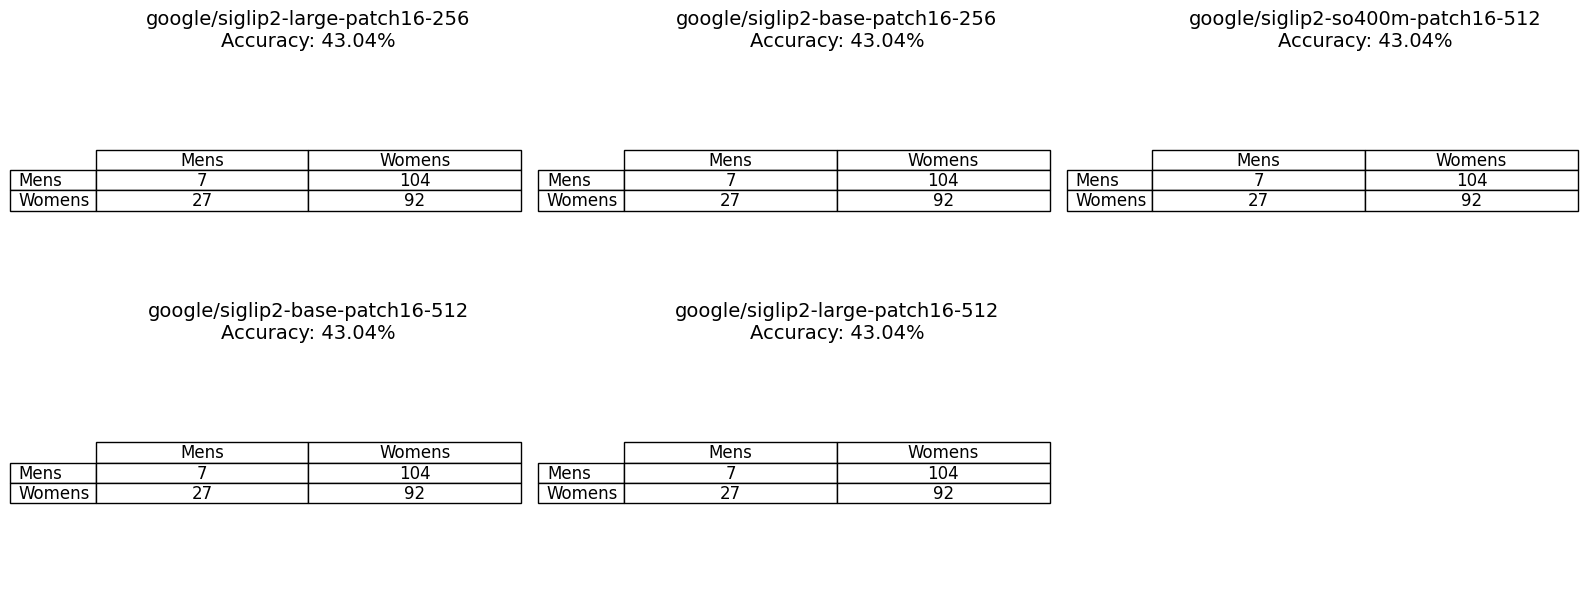

Evaluating checkpoint: google/siglip2-large-patch16-256


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:47<00:00,  4.88it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.91it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.92it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


/home/janweimer/Documents/github/AISA-Model-Test/utils2.py:54: UserWarning: The following named arguments are not valid for `SiglipModel.get_text_features` and were ignored: 'normalize'
  product_type_features = model.get_text_features(
100%|██████████| 230/230 [00:46<00:00,  4.92it/s]


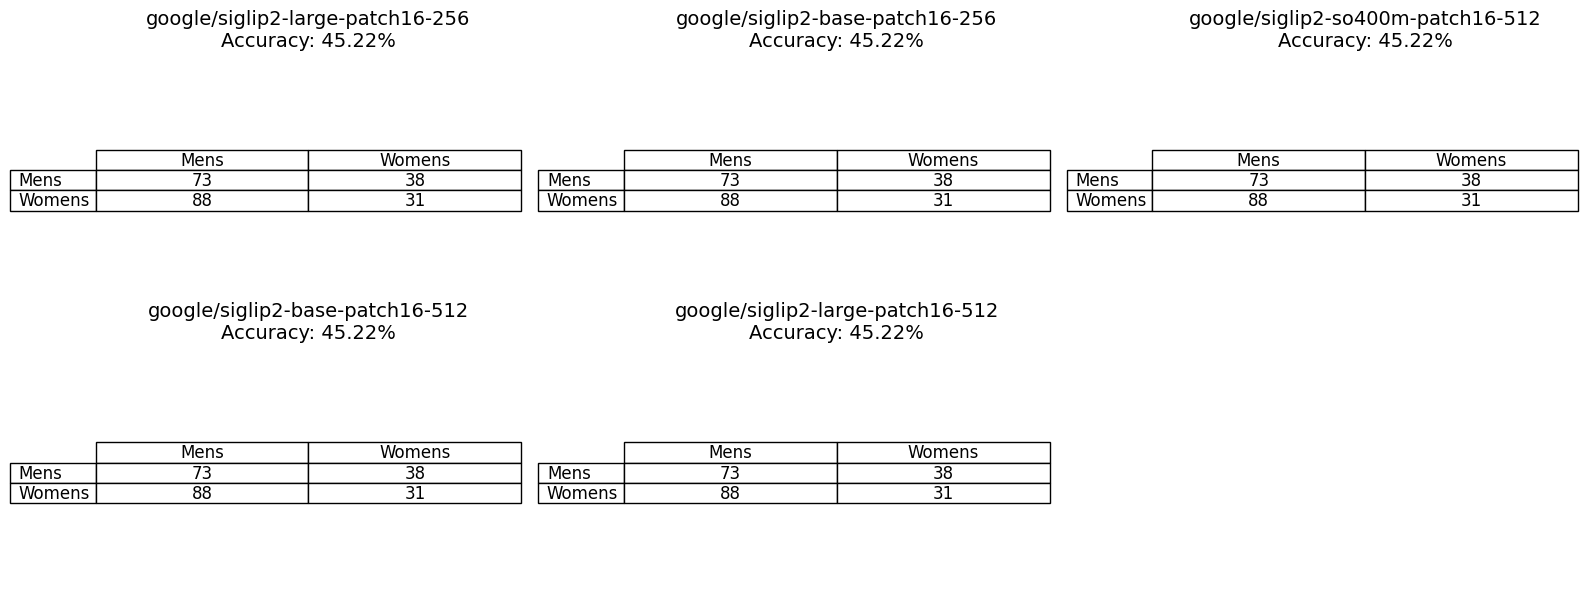

Evaluating checkpoint: google/siglip2-large-patch16-256


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [5]:
ds_temp = ds.match(fo.ViewField("Category three").contains(['Shirts', 'Tops & Blouses']))
candidate_labels_list = [
    ['female', 'male'], 
    ['a female shirt', 'a male shirt', 'a female top', 'a male top'],
    ['female', 'male' 'a shirt with breast pockets', 'a blouse'],
    ['female', 'male', 'a right buttoned shirt', 'a left buttoned shirt', 'a female top'], 

    ]


category = "Category two"

translate = {
    'female': 'Womens',
    'male': 'Mens',
    'a male shirt': 'Mens',
    'a female shirt': 'Womens',
    'a female top': 'Womens',
    'a male top': 'Mens',
    'a shirt with breast pockets': 'Mens',
    'a blouse': 'Womens',
     'a left buttoned shirt': 'Womens',
     'a rigth buttoned shirt': 'Mens',
}
checkpoints = [
    "google/siglip2-large-patch16-256",
    "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints, candidate_labels)

## Evaluate Material

Evaluating checkpoint: google/siglip2-large-patch16-256


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda
100%|██████████| 346/346 [00:11<00:00, 29.35it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 346/346 [00:06<00:00, 51.99it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 346/346 [00:30<00:00, 11.28it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 346/346 [00:11<00:00, 30.98it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 346/346 [00:23<00:00, 14.45it/s]


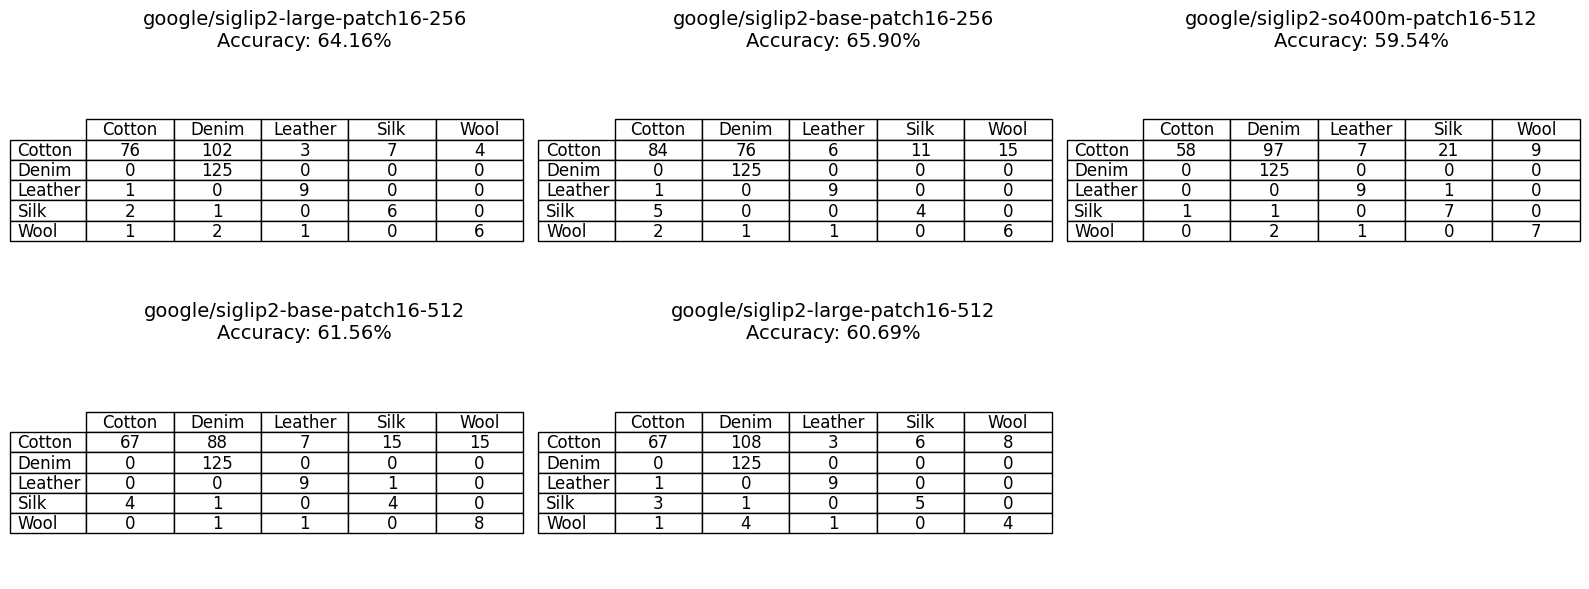

In [ ]:
materials= [
 'Cotton',
 'Denim',
 'Leather',
 'Silk',
 'Wool']
ds_temp = ds.match(fo.ViewField("Fabric/Material")[0].is_in(
    materials
))



category = 'Fabric/Material'

translate = {
    'woven': 'Cotton',
    'cotton': 'Cotton',
    'denim': 'Denim',
    'leather': 'Leather',
    'silk': 'Silk',
    'wool': 'Wool',
}
candidate_labels_list = [list(translate.keys())]

checkpoints = [
    "google/siglip2-large-patch16-256",
    "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints, candidate_labels)


# Product Category

Evaluating checkpoint: google/siglip2-large-patch16-256


Device set to use cuda
100%|██████████| 600/600 [00:18<00:00, 32.18it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 600/600 [00:10<00:00, 59.43it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 600/600 [00:51<00:00, 11.71it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 600/600 [00:18<00:00, 33.10it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 600/600 [00:39<00:00, 15.08it/s]


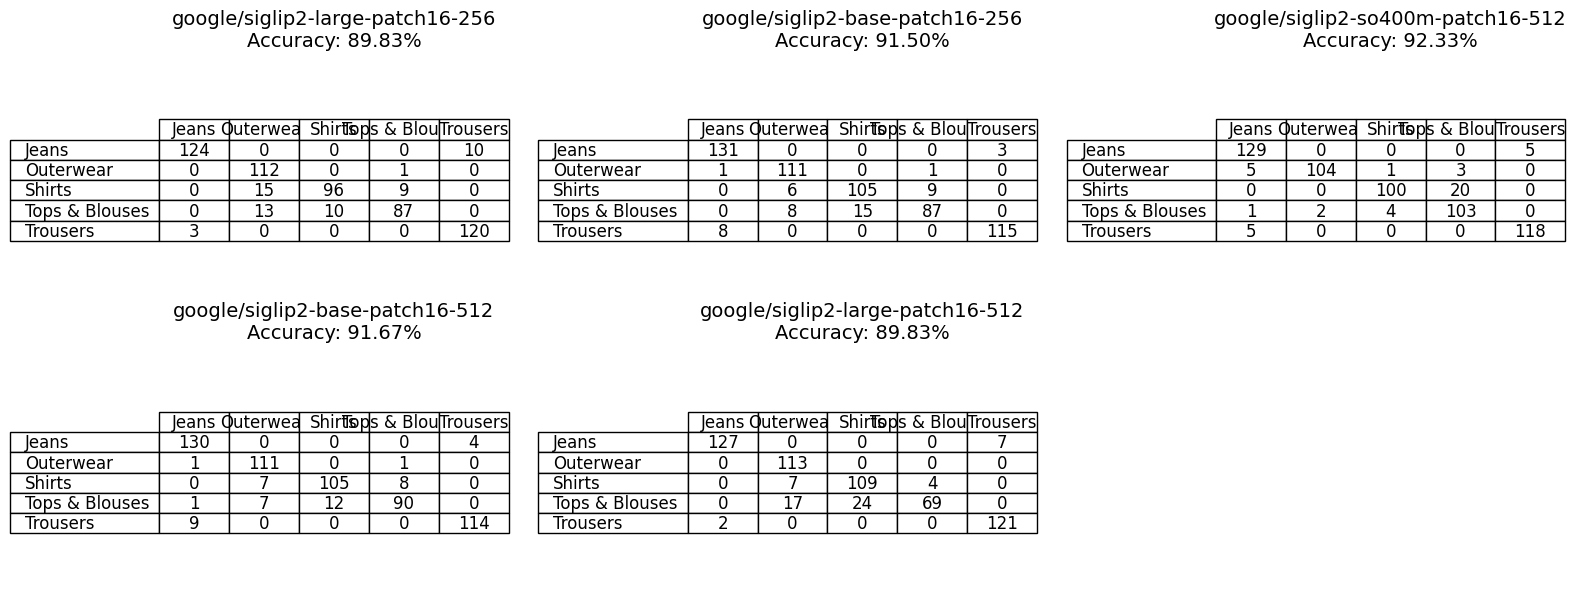

In [ ]:
ds_temp = ds
category = 'Category three'

translate = {
    'a photo of jeans': 'Jeans',
    'a photo of outerwear': 'Outerwear',
    'a photo of shirt': 'Shirts',
    'a photo of top': 'Tops & Blouses',
    'a photo of blouse': 'Tops & Blouses',
    'a photo of trousers': 'Trousers',
}
candidate_labels_list = [list(translate.keys())]

checkpoints = [
    "google/siglip2-large-patch16-256",
    "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints, candidate_labels, figsize=(20, 6))


# Shirt Style

Dataset:     2025.11.11.19.23.46.717909
Media type:  group
Group slice: 1
Num groups:  116
Group fields:
    id:                            fiftyone.core.fields.ObjectIdField
    filepath:                      fiftyone.core.fields.StringField
    tags:                          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:                    fiftyone.core.fields.DateTimeField
    last_modified_at:              fiftyone.core.fields.DateTimeField
    image_position:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    Blouse style:                  fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    Brand:                         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    Category one:                  fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)


Evaluating checkpoint: google/siglip2-so400m-patch16-512


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 799c9b3f-f93f-447a-aefb-b8e529c4220b)')' thrown while requesting HEAD https://huggingface.co/google/siglip2-so400m-patch16-512/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/siglip2-so400m-patch16-512/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7fb9b55b6950>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: d9f03b76-8e2a-4978-a38e-1ad33c61d252)')' thrown while requesting HEAD https://huggingface.co/google/siglip2-so400m-patch16-512/resolve/main/config.json
Retrying in 2s [Retry 2/5].
Device set to use cuda
100%|██████████| 116/116 [00:12<00:00,  9.45it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 116/116 [00:09<00:00, 12.16it/s]


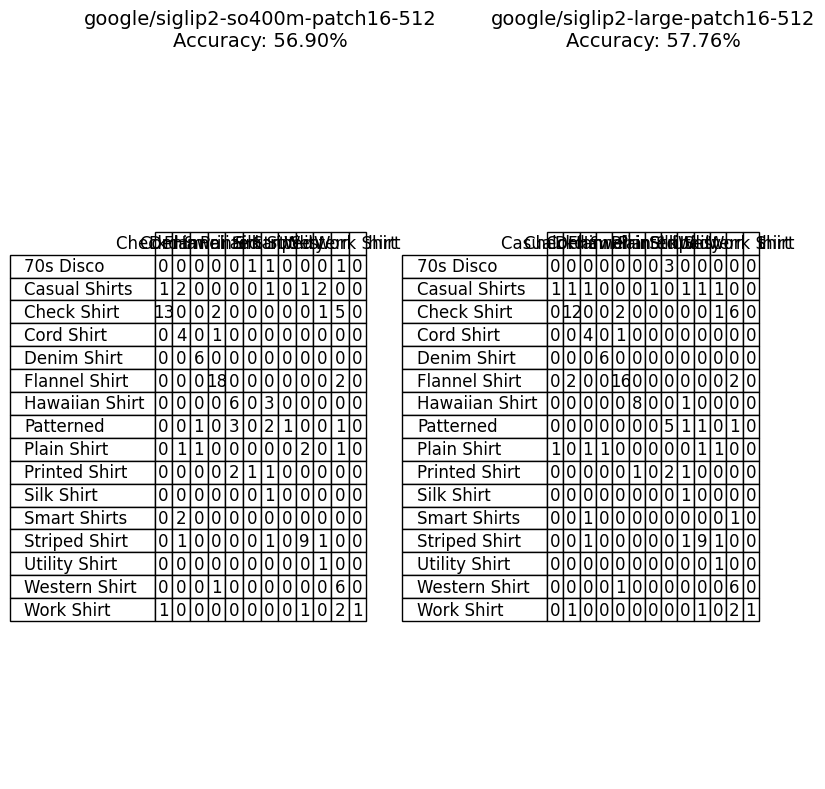

In [ ]:
ds_temp = ds.match(fo.ViewField("Shirt style").exists())

category = 'Shirt style'

translate = {
    'a 70s disco': '70s Disco',
    'a casual shirts': 'Casual Shirts',
    'a check shirt': 'Check Shirt',
    'a cord shirt': 'Cord Shirt',
    'a denim shirt': 'Denim Shirt',
    'a flannel shirt': 'Flannel Shirt',
    'a hawaiian shirt': 'Hawaiian Shirt',
    'a patterned': 'Patterned',
    'a plain shirt': 'Plain Shirt',
    'a printed shirt': 'Printed Shirt',
    'a silk shirt': 'Silk Shirt',
    'a smart shirts': 'Smart Shirts',
    'a striped shirt': 'Striped Shirt',
    'a utility shirt': 'Utility Shirt',
    'a western shirt': 'Western Shirt',
    'a work shirt': 'Work Shirt'
}


candidate_labels_list = [list(translate.keys())]

checkpoints = [
    # "google/siglip2-large-patch16-256",
    # "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    # "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints, candidate_labels, figsize=(8, 8), layout = (1,2))


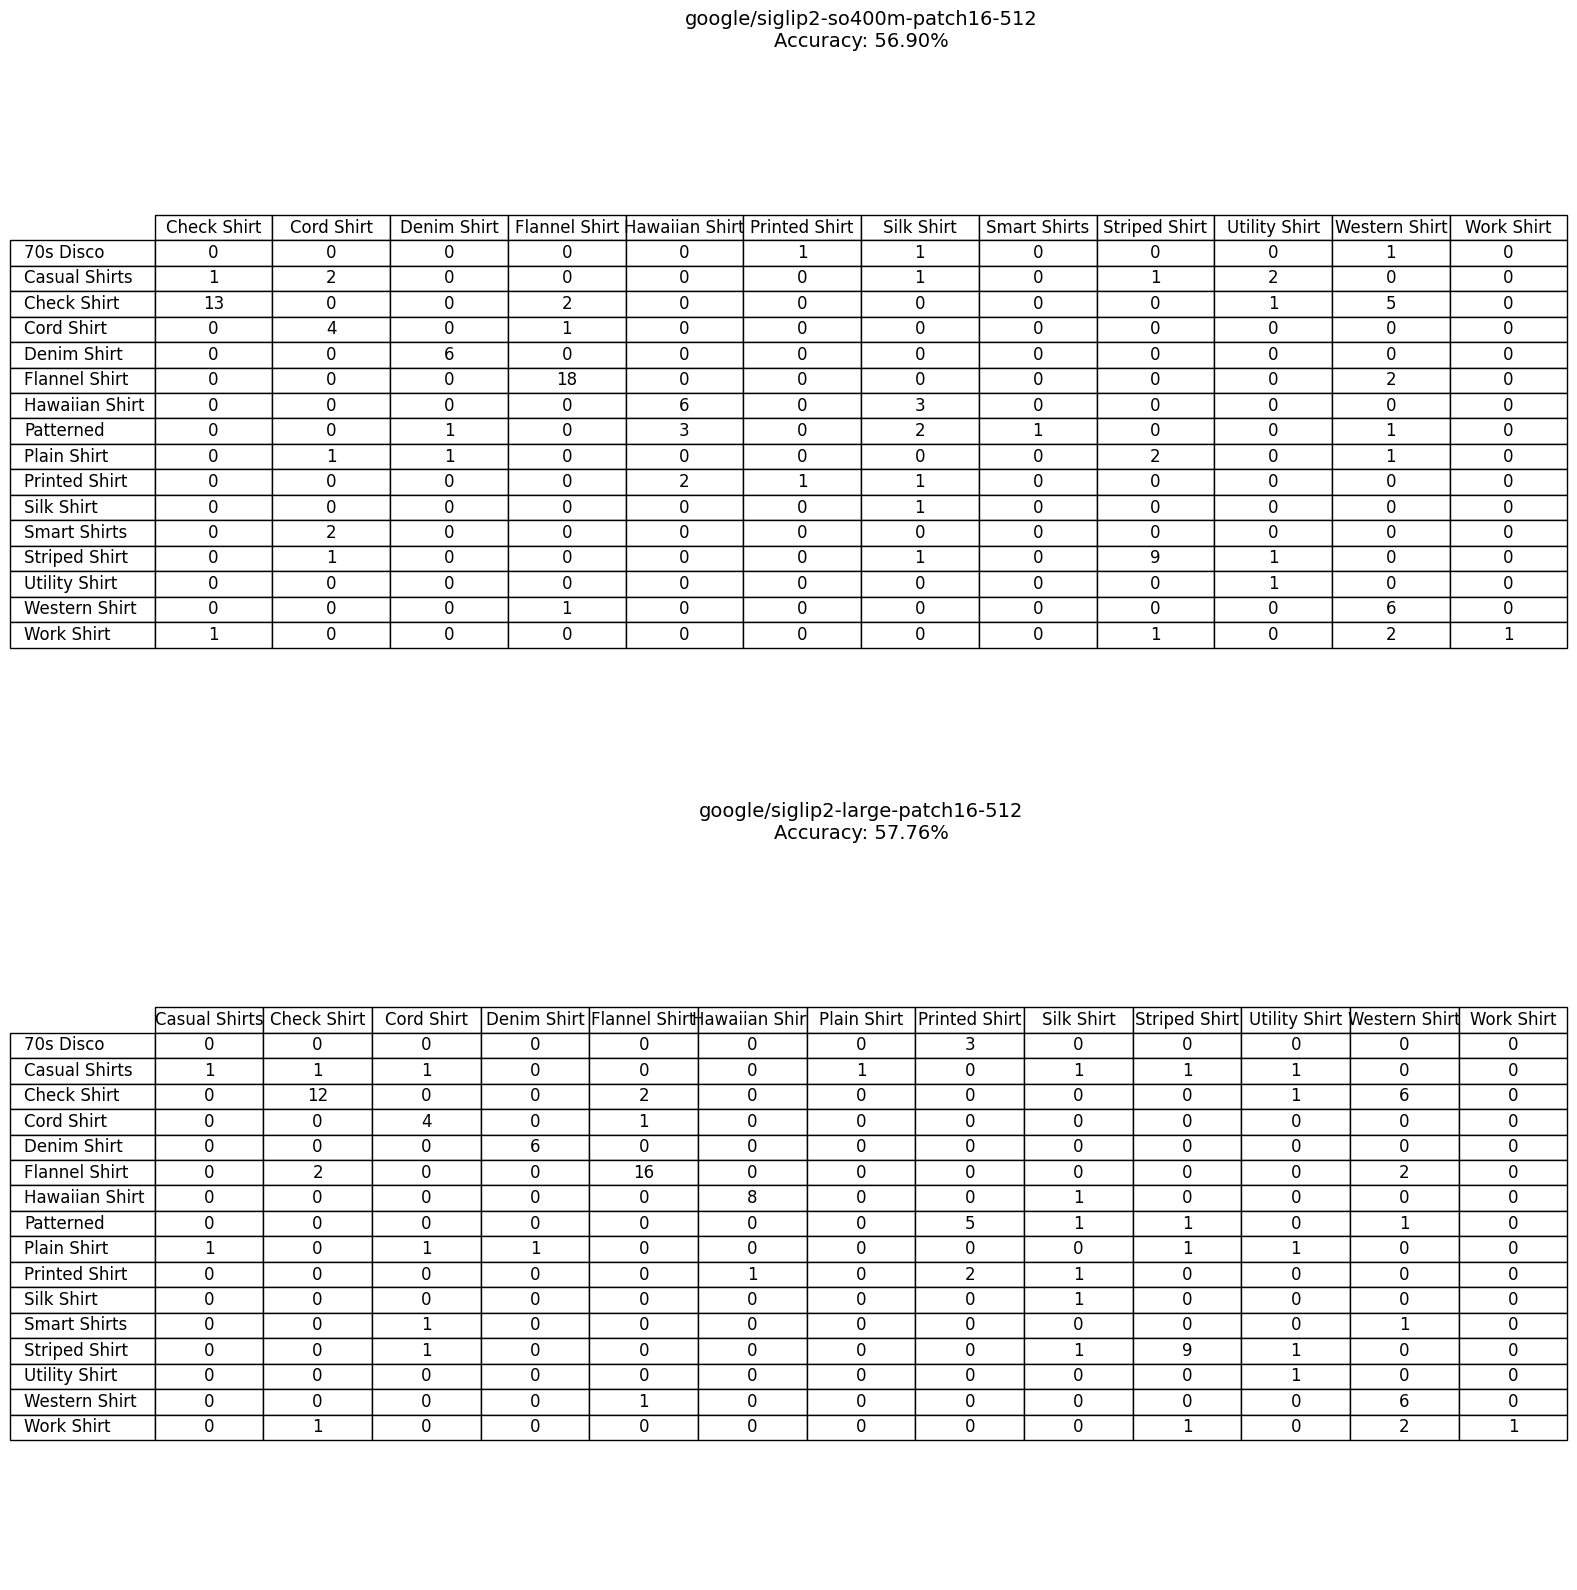

In [ ]:
    save_df(df_all, translate, checkpoints, candidate_labels, figsize=(16, 16), layout = (2,1))
